# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    #### Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size, interpolation=2),
                                    #transforms.RandomRotation(10),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor()])
        
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 64
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

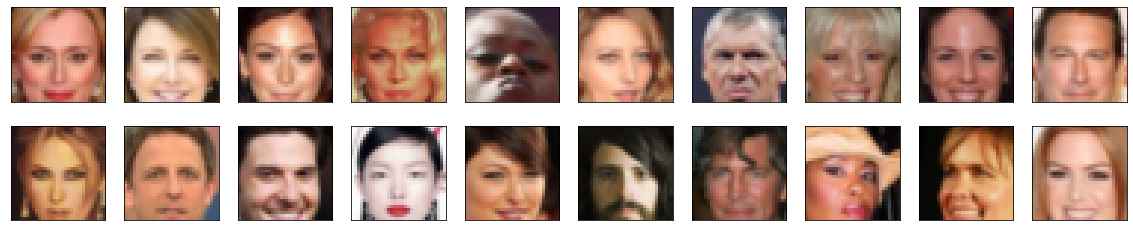

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
#### Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max-min) + min
    return x

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[8]
scaled_img = scale(img, feature_range=(-1, 1))

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9529)
Max:  tensor(0.7569)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim
        
        # complete init function
        self.conv1 = conv(in_channels=3,          out_channels=conv_dim*1, kernel_size=4, stride=2, padding=1, batch_norm=False) #32 --> 16
        self.conv2 = conv(in_channels=conv_dim*1, out_channels=conv_dim*2, kernel_size=4, stride=2, padding=1, batch_norm=True)  #16 --> 8
        self.conv3 = conv(in_channels=conv_dim*2, out_channels=conv_dim*4, kernel_size=4, stride=2, padding=1, batch_norm=True)  #8 --> 4
        
        self.fc1 = nn.Linear(conv_dim*4 * 4 * 4, 1) 
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv3(x), negative_slope=0.2)
        
        #flatten
        x = x.view(-1, self.conv_dim*4 * 4 * 4)  
        
        #use FC layer to output one answer shape = (batch_size, 1)
        x = self.fc1(x)
        
        #print("Discriminator output shape: {}".format(x.shape))
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    ## TODO: Complete this function
    ## create a sequence of transpose + optional batch norm layers
    layers = []
    
    t_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
    layers.append(t_conv)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)

class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        
        # complete init function
        self.fc_latent_into_conv = nn.Linear(z_size, conv_dim*4 * 4 * 4) #input layers * init width * init height
        
        # complete init function
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4, stride=2, padding=1, batch_norm=True)  #4  -> 8
        self.deconv2 = deconv(conv_dim*2, conv_dim*1, 4, stride=2, padding=1, batch_norm=True)  #8  -> 16
        self.deconv3 = deconv(conv_dim*1, 3,          4, stride=2, padding=1, batch_norm=False) #16 -> 32

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc_latent_into_conv(x) #latent input into size that feed into first conv layer
        
        x = x.view(-1, self.conv_dim*4, 4,  4) 
        
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.tanh(self.deconv3(x))
        #print("Generator output shape: {}".format(x.shape))
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


/home/nathan/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
from torch.nn import init

def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if classname == 'conv':
        init.normal_(m.weight.data, 0, 0.02)
    elif classname == 'Conv2d':
        init.normal_(m.weight.data, 0, 0.02)
    elif classname == 'ConvTranspose2d':
        init.normal_(m.weight.data, 0, 0.02)
    elif classname == 'BatchNorm2d':
        init.normal_(m.weight.data, 0, 0.02)
    elif classname == 'Linear':
        init.normal_(m.weight.data, 0, 0.02)
    elif classname == 'Sequential' or classname == 'Discriminator' or classname == 'Generator':
        #no init required
        print("init not required for class: {}".format(classname))
    else:
        print("init not defined for class: {}".format(classname))

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

init not required for class: Sequential
init not required for class: Sequential
init not required for class: Sequential
init not required for class: Discriminator
init not required for class: Sequential
init not required for class: Sequential
init not required for class: Sequential
init not required for class: Generator
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc_latent_into_conv): Linear(in_features=100, out_features=40

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [18]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [19]:
import torch.optim as optim

lr = 0.0002 #from the paper
beta1= 0.50
beta2= 0.999  #default value

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [20]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            #print("batch size from loader: {}".format(batch_size))
            real_images = scale(real_images)
            if train_on_gpu:
                real_images = real_images.cuda()
            
            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            d_optimizer.zero_grad()
            
            # 1. Train the discriminator on real and fake images
            # 1a. get some real images to train the discriminator. Get the Discriminator's output (guesses)
            discriminator_out_real = D(real_images)
            # 1b. calculate the discriminator's loss at judging if images are real.
            discriminator_real_loss = real_loss(discriminator_out_real, smooth=True)
            
            # 1c. generate some fake images.
            latent_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            latent_z = torch.from_numpy(latent_z).float()
            if train_on_gpu:
                latent_z = latent_z.cuda()
            generated_fake_images = G(latent_z)
            discriminator_out_fake = D(generated_fake_images)
            # 1d. calculate the discriminator's loss at judging if images are fake.
            discriminator_fake_loss = fake_loss(discriminator_out_fake)
            
            # 1e. add losses and run backprop
            d_loss = discriminator_real_loss + discriminator_fake_loss
            d_loss.backward()
            d_optimizer.step()
        
        
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()

            # 2a. generate some fake images.
            latent_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            latent_z = torch.from_numpy(latent_z).float()
            if train_on_gpu:
                latent_z = latent_z.cuda()
            generated_fake_images = G(latent_z)
            
            # 2b Compute the discriminator losses on fake images 
            discriminator_out_fake = D(generated_fake_images)
            g_loss = real_loss(discriminator_out_fake) # use real loss to flip labels
            g_loss.backward()
            g_optimizer.step()
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [21]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.3815 | g_loss: 0.7175
Epoch [    1/   50] | d_loss: 0.6211 | g_loss: 1.6281
Epoch [    1/   50] | d_loss: 0.4201 | g_loss: 2.6316
Epoch [    1/   50] | d_loss: 0.3726 | g_loss: 3.3324
Epoch [    1/   50] | d_loss: 0.4169 | g_loss: 3.2014
Epoch [    1/   50] | d_loss: 0.4119 | g_loss: 3.2756
Epoch [    1/   50] | d_loss: 0.4882 | g_loss: 3.3509
Epoch [    1/   50] | d_loss: 0.6533 | g_loss: 1.5945
Epoch [    1/   50] | d_loss: 1.7299 | g_loss: 3.3546
Epoch [    1/   50] | d_loss: 0.7515 | g_loss: 1.5080
Epoch [    1/   50] | d_loss: 1.0060 | g_loss: 1.4770
Epoch [    1/   50] | d_loss: 0.9265 | g_loss: 1.9198
Epoch [    1/   50] | d_loss: 0.8389 | g_loss: 1.7772
Epoch [    1/   50] | d_loss: 0.9736 | g_loss: 2.2181
Epoch [    1/   50] | d_loss: 0.8884 | g_loss: 2.1590
Epoch [    1/   50] | d_loss: 1.0623 | g_loss: 1.4329
Epoch [    1/   50] | d_loss: 1.0907 | g_loss: 1.0957
Epoch [    1/   50] | d_loss: 1.2601 | g_loss: 1.1632
Epoch [    1/   50] | d_loss

Epoch [    6/   50] | d_loss: 1.2583 | g_loss: 2.1789
Epoch [    6/   50] | d_loss: 1.0880 | g_loss: 0.8731
Epoch [    6/   50] | d_loss: 1.1827 | g_loss: 0.9568
Epoch [    6/   50] | d_loss: 1.1031 | g_loss: 1.0390
Epoch [    6/   50] | d_loss: 0.9783 | g_loss: 1.2383
Epoch [    6/   50] | d_loss: 1.3187 | g_loss: 1.8395
Epoch [    6/   50] | d_loss: 1.1168 | g_loss: 0.9334
Epoch [    6/   50] | d_loss: 1.0658 | g_loss: 1.1202
Epoch [    6/   50] | d_loss: 1.1852 | g_loss: 1.2791
Epoch [    6/   50] | d_loss: 1.0487 | g_loss: 1.2967
Epoch [    6/   50] | d_loss: 1.0419 | g_loss: 0.8913
Epoch [    6/   50] | d_loss: 1.0309 | g_loss: 1.4374
Epoch [    6/   50] | d_loss: 1.0012 | g_loss: 1.5220
Epoch [    6/   50] | d_loss: 1.0202 | g_loss: 1.3869
Epoch [    6/   50] | d_loss: 1.0910 | g_loss: 1.0438
Epoch [    6/   50] | d_loss: 1.1538 | g_loss: 1.1039
Epoch [    6/   50] | d_loss: 1.2286 | g_loss: 0.9274
Epoch [    6/   50] | d_loss: 0.9525 | g_loss: 1.2427
Epoch [    6/   50] | d_loss

Epoch [   11/   50] | d_loss: 0.8015 | g_loss: 1.9112
Epoch [   11/   50] | d_loss: 0.7400 | g_loss: 2.5079
Epoch [   11/   50] | d_loss: 1.5636 | g_loss: 0.8360
Epoch [   11/   50] | d_loss: 0.7198 | g_loss: 1.4990
Epoch [   11/   50] | d_loss: 0.9053 | g_loss: 2.6993
Epoch [   11/   50] | d_loss: 0.7039 | g_loss: 1.4779
Epoch [   11/   50] | d_loss: 0.7278 | g_loss: 2.7301
Epoch [   11/   50] | d_loss: 0.9120 | g_loss: 1.4845
Epoch [   11/   50] | d_loss: 0.6608 | g_loss: 2.0795
Epoch [   11/   50] | d_loss: 0.8995 | g_loss: 1.5307
Epoch [   11/   50] | d_loss: 0.7197 | g_loss: 1.2297
Epoch [   11/   50] | d_loss: 0.8656 | g_loss: 1.4657
Epoch [   11/   50] | d_loss: 1.2717 | g_loss: 1.1036
Epoch [   11/   50] | d_loss: 0.7747 | g_loss: 1.5998
Epoch [   11/   50] | d_loss: 0.7703 | g_loss: 1.5090
Epoch [   12/   50] | d_loss: 1.0352 | g_loss: 3.0593
Epoch [   12/   50] | d_loss: 1.0072 | g_loss: 3.5642
Epoch [   12/   50] | d_loss: 0.8197 | g_loss: 2.7277
Epoch [   12/   50] | d_loss

Epoch [   16/   50] | d_loss: 0.6788 | g_loss: 2.5701
Epoch [   16/   50] | d_loss: 0.5126 | g_loss: 2.9108
Epoch [   16/   50] | d_loss: 0.7196 | g_loss: 3.2165
Epoch [   16/   50] | d_loss: 0.5913 | g_loss: 2.2491
Epoch [   16/   50] | d_loss: 0.9256 | g_loss: 0.9798
Epoch [   16/   50] | d_loss: 0.7208 | g_loss: 1.7525
Epoch [   16/   50] | d_loss: 0.6834 | g_loss: 2.8635
Epoch [   16/   50] | d_loss: 0.9777 | g_loss: 1.0406
Epoch [   17/   50] | d_loss: 0.6163 | g_loss: 1.9346
Epoch [   17/   50] | d_loss: 0.5976 | g_loss: 2.2829
Epoch [   17/   50] | d_loss: 0.6414 | g_loss: 1.5251
Epoch [   17/   50] | d_loss: 0.5570 | g_loss: 2.8176
Epoch [   17/   50] | d_loss: 0.6393 | g_loss: 1.7474
Epoch [   17/   50] | d_loss: 0.5314 | g_loss: 2.2982
Epoch [   17/   50] | d_loss: 0.5156 | g_loss: 3.1198
Epoch [   17/   50] | d_loss: 0.7952 | g_loss: 3.8061
Epoch [   17/   50] | d_loss: 0.5534 | g_loss: 2.0961
Epoch [   17/   50] | d_loss: 0.5656 | g_loss: 2.7652
Epoch [   17/   50] | d_loss

Epoch [   21/   50] | d_loss: 0.7354 | g_loss: 3.3314
Epoch [   22/   50] | d_loss: 0.5942 | g_loss: 1.8734
Epoch [   22/   50] | d_loss: 0.5174 | g_loss: 2.6049
Epoch [   22/   50] | d_loss: 0.4928 | g_loss: 2.5858
Epoch [   22/   50] | d_loss: 0.6172 | g_loss: 2.9881
Epoch [   22/   50] | d_loss: 0.4769 | g_loss: 2.6782
Epoch [   22/   50] | d_loss: 0.4507 | g_loss: 2.5582
Epoch [   22/   50] | d_loss: 0.4928 | g_loss: 3.6537
Epoch [   22/   50] | d_loss: 0.6455 | g_loss: 2.1993
Epoch [   22/   50] | d_loss: 0.5638 | g_loss: 2.6000
Epoch [   22/   50] | d_loss: 0.5598 | g_loss: 2.6214
Epoch [   22/   50] | d_loss: 0.5933 | g_loss: 3.1784
Epoch [   22/   50] | d_loss: 0.5529 | g_loss: 2.6501
Epoch [   22/   50] | d_loss: 0.6904 | g_loss: 1.8098
Epoch [   22/   50] | d_loss: 0.7376 | g_loss: 2.3896
Epoch [   22/   50] | d_loss: 0.6311 | g_loss: 3.3039
Epoch [   22/   50] | d_loss: 1.6041 | g_loss: 6.1637
Epoch [   22/   50] | d_loss: 0.6132 | g_loss: 2.6286
Epoch [   22/   50] | d_loss

Epoch [   27/   50] | d_loss: 0.5240 | g_loss: 2.9456
Epoch [   27/   50] | d_loss: 0.4068 | g_loss: 3.3780
Epoch [   27/   50] | d_loss: 2.3039 | g_loss: 0.2213
Epoch [   27/   50] | d_loss: 0.4840 | g_loss: 2.2774
Epoch [   27/   50] | d_loss: 0.5449 | g_loss: 3.4130
Epoch [   27/   50] | d_loss: 0.4626 | g_loss: 3.5924
Epoch [   27/   50] | d_loss: 0.4760 | g_loss: 2.8397
Epoch [   27/   50] | d_loss: 0.6556 | g_loss: 1.8367
Epoch [   27/   50] | d_loss: 0.4866 | g_loss: 3.7676
Epoch [   27/   50] | d_loss: 0.4558 | g_loss: 3.0608
Epoch [   27/   50] | d_loss: 0.5742 | g_loss: 1.9579
Epoch [   27/   50] | d_loss: 0.4763 | g_loss: 3.1537
Epoch [   27/   50] | d_loss: 0.4330 | g_loss: 2.9972
Epoch [   27/   50] | d_loss: 1.6951 | g_loss: 4.7858
Epoch [   27/   50] | d_loss: 0.5997 | g_loss: 1.5889
Epoch [   27/   50] | d_loss: 0.6894 | g_loss: 1.8034
Epoch [   27/   50] | d_loss: 0.5402 | g_loss: 3.1443
Epoch [   27/   50] | d_loss: 0.4624 | g_loss: 2.5502
Epoch [   27/   50] | d_loss

Epoch [   32/   50] | d_loss: 0.5038 | g_loss: 3.8355
Epoch [   32/   50] | d_loss: 0.4723 | g_loss: 2.7047
Epoch [   32/   50] | d_loss: 0.7078 | g_loss: 1.3088
Epoch [   32/   50] | d_loss: 0.4956 | g_loss: 3.0814
Epoch [   32/   50] | d_loss: 0.6643 | g_loss: 2.0520
Epoch [   32/   50] | d_loss: 0.4466 | g_loss: 2.4987
Epoch [   32/   50] | d_loss: 0.6276 | g_loss: 4.3077
Epoch [   32/   50] | d_loss: 2.3659 | g_loss: 6.1319
Epoch [   32/   50] | d_loss: 0.4672 | g_loss: 2.9758
Epoch [   32/   50] | d_loss: 0.4670 | g_loss: 3.0632
Epoch [   32/   50] | d_loss: 0.4280 | g_loss: 4.2396
Epoch [   32/   50] | d_loss: 0.4861 | g_loss: 2.3704
Epoch [   32/   50] | d_loss: 0.5141 | g_loss: 3.5078
Epoch [   32/   50] | d_loss: 1.8932 | g_loss: 1.0427
Epoch [   32/   50] | d_loss: 0.5895 | g_loss: 1.8053
Epoch [   32/   50] | d_loss: 0.4682 | g_loss: 3.1178
Epoch [   33/   50] | d_loss: 0.5330 | g_loss: 3.3587
Epoch [   33/   50] | d_loss: 0.4434 | g_loss: 3.0895
Epoch [   33/   50] | d_loss

Epoch [   37/   50] | d_loss: 0.4302 | g_loss: 3.9442
Epoch [   37/   50] | d_loss: 0.4719 | g_loss: 3.5875
Epoch [   37/   50] | d_loss: 0.3987 | g_loss: 3.5742
Epoch [   37/   50] | d_loss: 0.4298 | g_loss: 3.1477
Epoch [   37/   50] | d_loss: 0.4194 | g_loss: 4.1860
Epoch [   37/   50] | d_loss: 0.5185 | g_loss: 3.3033
Epoch [   37/   50] | d_loss: 0.4390 | g_loss: 4.2370
Epoch [   37/   50] | d_loss: 0.5213 | g_loss: 3.9284
Epoch [   37/   50] | d_loss: 0.4038 | g_loss: 3.6113
Epoch [   38/   50] | d_loss: 2.5930 | g_loss: 5.6059
Epoch [   38/   50] | d_loss: 0.5069 | g_loss: 2.7943
Epoch [   38/   50] | d_loss: 0.4231 | g_loss: 4.3471
Epoch [   38/   50] | d_loss: 0.6637 | g_loss: 4.0403
Epoch [   38/   50] | d_loss: 0.4422 | g_loss: 3.5865
Epoch [   38/   50] | d_loss: 0.4074 | g_loss: 3.5333
Epoch [   38/   50] | d_loss: 0.4526 | g_loss: 4.3404
Epoch [   38/   50] | d_loss: 0.5175 | g_loss: 3.0830
Epoch [   38/   50] | d_loss: 0.4963 | g_loss: 2.9491
Epoch [   38/   50] | d_loss

Epoch [   42/   50] | d_loss: 0.7806 | g_loss: 2.8370
Epoch [   42/   50] | d_loss: 0.5133 | g_loss: 3.4574
Epoch [   43/   50] | d_loss: 0.4295 | g_loss: 3.3326
Epoch [   43/   50] | d_loss: 0.6082 | g_loss: 2.1894
Epoch [   43/   50] | d_loss: 0.4555 | g_loss: 2.9318
Epoch [   43/   50] | d_loss: 0.4815 | g_loss: 3.9292
Epoch [   43/   50] | d_loss: 0.4730 | g_loss: 3.8588
Epoch [   43/   50] | d_loss: 1.8854 | g_loss: 3.4059
Epoch [   43/   50] | d_loss: 0.4816 | g_loss: 4.3312
Epoch [   43/   50] | d_loss: 0.5104 | g_loss: 4.6107
Epoch [   43/   50] | d_loss: 0.5670 | g_loss: 3.2762
Epoch [   43/   50] | d_loss: 0.4517 | g_loss: 4.1931
Epoch [   43/   50] | d_loss: 0.5043 | g_loss: 4.6796
Epoch [   43/   50] | d_loss: 0.4379 | g_loss: 3.7047
Epoch [   43/   50] | d_loss: 0.4048 | g_loss: 3.2632
Epoch [   43/   50] | d_loss: 0.4549 | g_loss: 4.9232
Epoch [   43/   50] | d_loss: 0.4087 | g_loss: 4.8323
Epoch [   43/   50] | d_loss: 0.4271 | g_loss: 3.8986
Epoch [   43/   50] | d_loss

Epoch [   48/   50] | d_loss: 0.8363 | g_loss: 2.2173
Epoch [   48/   50] | d_loss: 0.4173 | g_loss: 3.5063
Epoch [   48/   50] | d_loss: 0.6837 | g_loss: 3.1329
Epoch [   48/   50] | d_loss: 0.3907 | g_loss: 4.1551
Epoch [   48/   50] | d_loss: 0.4384 | g_loss: 3.0126
Epoch [   48/   50] | d_loss: 0.5286 | g_loss: 3.3701
Epoch [   48/   50] | d_loss: 0.4338 | g_loss: 4.5687
Epoch [   48/   50] | d_loss: 0.4628 | g_loss: 3.6003
Epoch [   48/   50] | d_loss: 0.3944 | g_loss: 3.8510
Epoch [   48/   50] | d_loss: 0.4077 | g_loss: 4.4512
Epoch [   48/   50] | d_loss: 0.4308 | g_loss: 3.7044
Epoch [   48/   50] | d_loss: 0.4503 | g_loss: 3.9210
Epoch [   48/   50] | d_loss: 0.4329 | g_loss: 3.6972
Epoch [   48/   50] | d_loss: 0.4590 | g_loss: 3.2718
Epoch [   48/   50] | d_loss: 0.3839 | g_loss: 4.2947
Epoch [   48/   50] | d_loss: 0.4505 | g_loss: 3.5584
Epoch [   48/   50] | d_loss: 0.4308 | g_loss: 3.2480
Epoch [   48/   50] | d_loss: 0.3835 | g_loss: 3.5853
Epoch [   48/   50] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

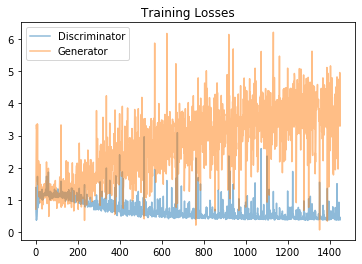

In [22]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [26]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [27]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

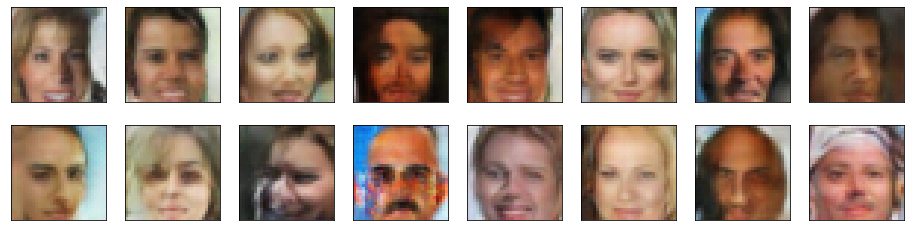

In [45]:
_ = view_samples(19, samples)

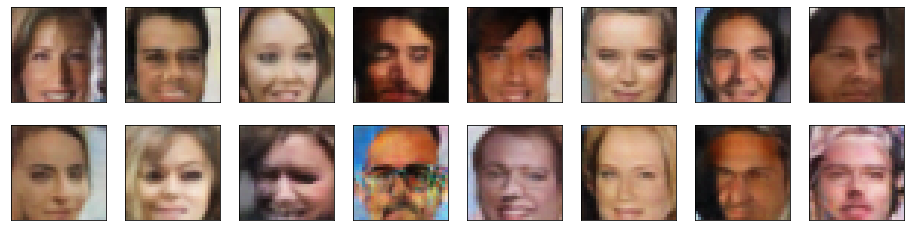

In [46]:
_ = view_samples(29, samples)

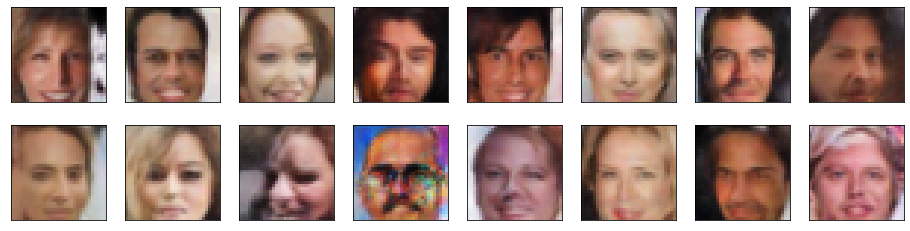

In [50]:
_ = view_samples(39, samples)

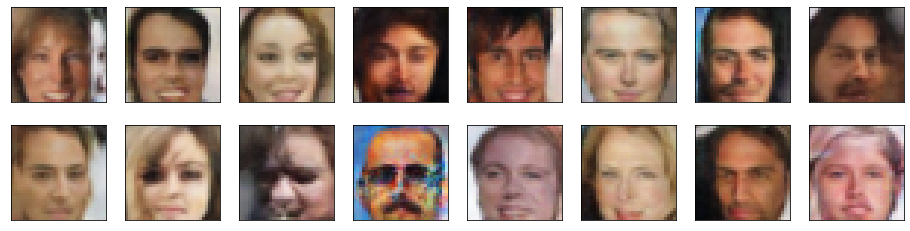

In [48]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)
I am impressed with how well the GAN did with generating faces.  They look convincing from a distance.  I plan on creating a branch to re-train with double the resolution and adding a method to generate a random face on demand.  Maybe generate 100 and return the top 10 that the discriminator thinks are the best.

A biased dataset should allow the model to create more believeable images.  More variation on the data means more to learn from a limited model size.  Taken to the extreme, it would be possible to train on random pictures of anything.  The results would probably not be convincing.

Increasing the model size should produce better images, but that the expense of CPU time.  My 50 epochs seems to do pretty well after about 2 hours of training.  As-is, I feel it is at a happy medium.

It takes some time to run and validate optimizer settings, so I didn't experiment much.  I doubt there is much to be improved upon. Maybe lowering the learning rate by half and training for another 50 epochs would produce marginally better images.

I printed out images at epochs 20, 30, 40, and 50.  I think it is still improving at epoch 50,  but slowly.



### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.